# Paper plots

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from importlib import reload
import s2wav
import s2fft
import scatcovjax.plotting as plot

from s2wav.filter_factory.filters import filters_directional_vectorised

plot.notebook_plot_format()

In [2]:
save_plot_dir = '/obs/lmousset/projet/paper_plots/'

# Figure 1: filters

In [7]:
sampling = "mw"
multiresolution = True
reality = True

N = 3
L = 256
J_min = 1
lam=2

J_max = s2wav.utils.shapes.j_max(L)
J = J_max - J_min + 1
print(J_max, J)

8 8


<IPython.core.display.Javascript object>


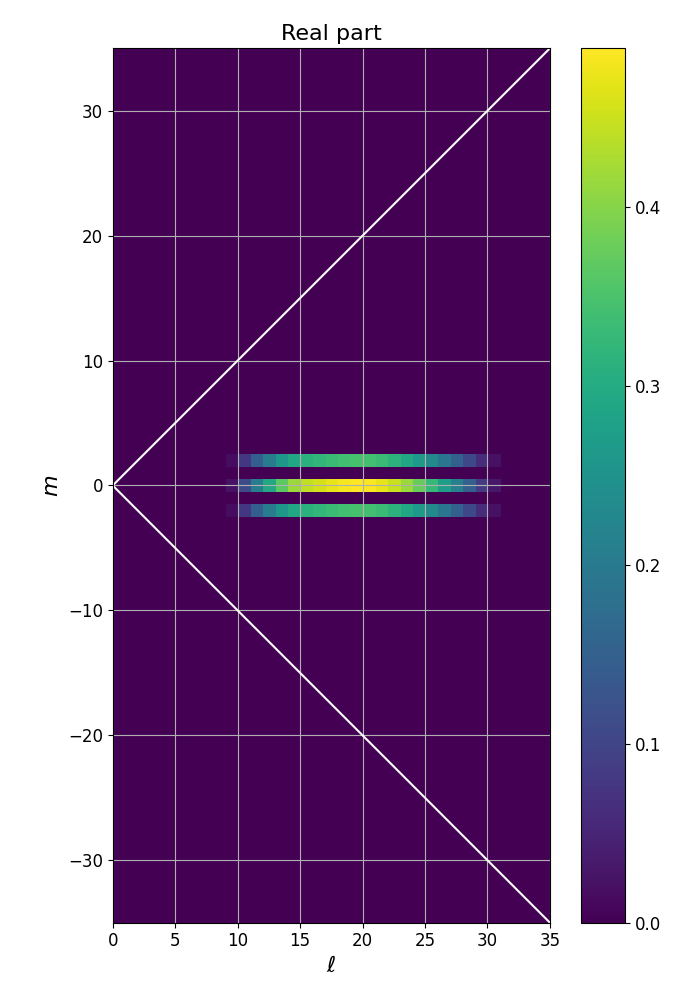

In [8]:
reload(plot)
# Generate the filters
filters = filters_directional_vectorised(L, N, J_min)

# Split the wavelet set and the scaling function
wlm, slm = filters

# Plot the (l,m) plane
j = 4
fig = plot.plot_alm(wlm[j, :, :], lmin=0, lmax=35, mmin=-35, mmax=35, plot_only_real_part=True, figsize=(7, 10))
fig.tight_layout()
fig.savefig(save_plot_dir + 'filter_lm.pdf')

<IPython.core.display.Javascript object>


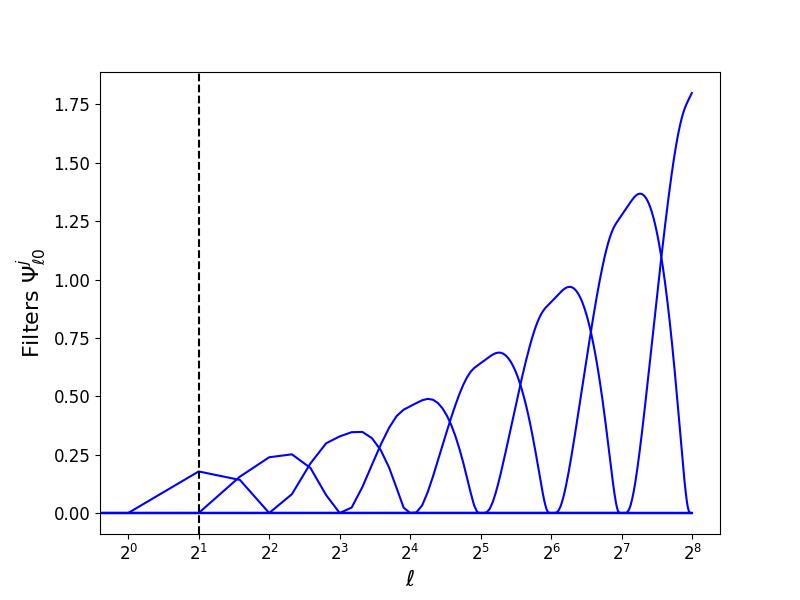

In [9]:
reload(plot)
# Plot the wavelets for a given n
fig1 = plot.plot_filters(filters, J_min=J_min, J_max=J_max, real=True, m=L-1)
lmin = int(lam**J_min)
plt.axvline(lmin, color='k', ls='--')

plt.savefig(save_plot_dir + 'filter_cut.pdf')

# Figure 2 Convolution d'un Dirac Multiresolution=False

In [40]:
### Parameters
sampling = "mw"
multiresolution = False
reality = True

N = 2
L = 256
J_min = 1

J_max = s2wav.utils.shapes.j_max(L)
J = J_max - J_min + 1
print(J_max, J)

### Filters
filters = filters_directional_vectorised(L, N, J_min)
# Split the wavelet set and the scaling function
wlm, slm = filters

### Make the map
f_dirac = np.zeros((L, 2*L-1))
f_dirac[L//2, L] = 1

#fig = plot.plot_map_MW_Mollweide(f_dirac, central_longitude=0)

# Make the SHT
flm_dirac = s2fft.forward_jax(f_dirac, L=L)

### Wavelet transform
W_dirac = s2wav.flm_to_analysis(
    flm_dirac,
    L,
    N,
    J_min,
    sampling=sampling,
    nside=None,
    reality=False,
    multiresolution=multiresolution,
    filters=wlm,
    precomps=None
)


8 8


<IPython.core.display.Javascript object>


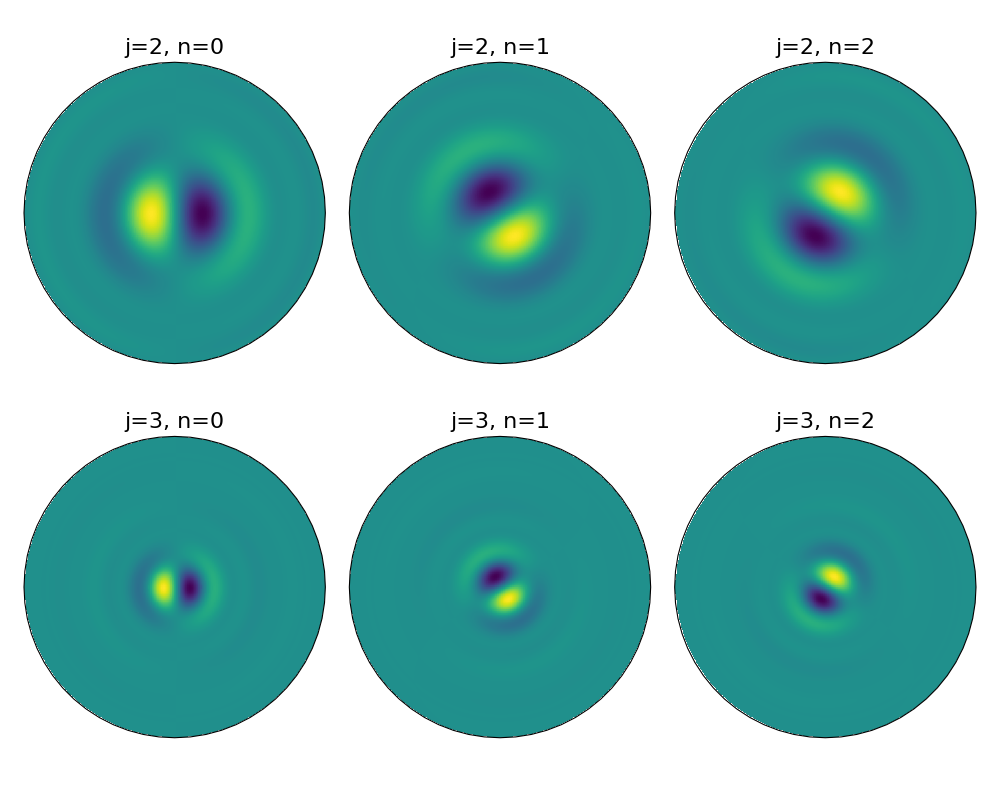

In [75]:
import cartopy.crs as ccrs

lat=0

fig, axs = plt.subplots(2, 2*N-1, 
                        subplot_kw={'projection': ccrs.Orthographic(central_longitude=0,
                                                   central_latitude=lat,
                                                   globe=None)},
                        figsize=(10, 8))
axs = axs.ravel()

i=0
for j in [2, 3]:
    for n in range(2*N-1):
        axs[i].imshow(np.real(W_dirac[j][n, :, :]), transform=ccrs.PlateCarree())
        axs[i].set_title(f'{j=}, {n=}')
        i+=1

fig.tight_layout()

fig.savefig(save_plot_dir + 'Dirac_conv.pdf')

# Figure 3: Convolution d'un Dirac Multiresolution=True

In [76]:
### Parameters
sampling = "mw"
multiresolution = True
reality = True

N = 2
L = 256
J_min = 1

J_max = s2wav.utils.shapes.j_max(L)
J = J_max - J_min + 1
print(J_max, J)

### Filters
filters = filters_directional_vectorised(L, N, J_min)
# Split the wavelet set and the scaling function
wlm, slm = filters

### Make the map
f_dirac = np.zeros((L, 2*L-1))
f_dirac[L//2, L] = 1

#fig = plot.plot_map_MW_Mollweide(f_dirac, central_longitude=0)

# Make the SHT
flm_dirac = s2fft.forward_jax(f_dirac, L=L)

### Wavelet transform
W_dirac = s2wav.flm_to_analysis(
    flm_dirac,
    L,
    N,
    J_min,
    sampling=sampling,
    nside=None,
    reality=False,
    multiresolution=multiresolution,
    filters=wlm,
    precomps=None
)


8 8


<IPython.core.display.Javascript object>


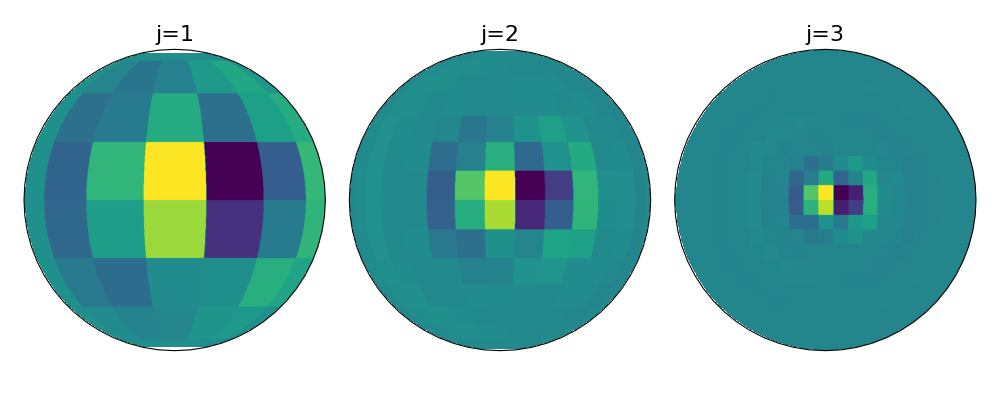

In [78]:
import cartopy.crs as ccrs

lat=0

fig, axs = plt.subplots(1, 3, 
                        subplot_kw={'projection': ccrs.Orthographic(central_longitude=0,
                                                   central_latitude=lat,
                                                   globe=None)},
                        figsize=(10, 4))
axs = axs.ravel()

i=0
for j in [1, 2, 3]:
    for n in [0]:
        axs[i].imshow(np.real(W_dirac[j][n, :, :]), transform=ccrs.PlateCarree())
        axs[i].set_title(f'{j=}')
        i+=1

fig.tight_layout()

fig.savefig(save_plot_dir + 'Multires.pdf')

# Figure 4: maps

In [27]:
sky = 'tsz'
target = np.load(save_plot_dir + f'target_map_{sky}.npy')
gauss = np.load(save_plot_dir + f'gauss_map_{sky}.npy')
end = np.load(save_plot_dir + f'end_map_{sky}.npy')


<IPython.core.display.Javascript object>


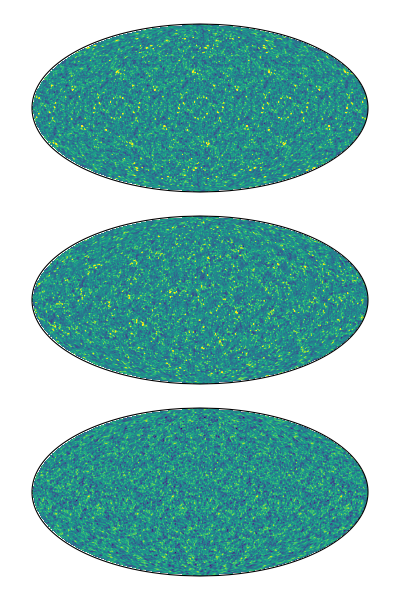

In [28]:
import cartopy.crs as ccrs


if sky in ['lss', 'lensing']:
    mn, mx = -1, 3
else:
    mn, mx = -2, 2
    
rotated_pole = ccrs.RotatedPole(pole_latitude=90, pole_longitude=180)

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, 
                        subplot_kw={'projection':ccrs.Mollweide(central_longitude=0)},
                        figsize=(4, 6))

ax0.imshow(target, transform=rotated_pole, vmin=mn, vmax=mx)
ax1.imshow(end, transform=rotated_pole, vmin=mn, vmax=mx)
ax2.imshow(gauss, transform=rotated_pole, vmin=mn, vmax=mx)

fig.tight_layout()

fig.savefig(save_plot_dir + f'maps_{sky}.pdf')

# Coeffs scatcov

In [6]:
sky = 'lensing'

# Target
tS1 = np.load(save_plot_dir + f'S1_target_{sky}.npy')
tP00 = np.load(save_plot_dir + f'P00_target_{sky}.npy')
tC01 = np.load(save_plot_dir + f'C01_target_{sky}.npy')
tC11 = np.load(save_plot_dir + f'C11_target_{sky}.npy')

# Gaussian
meanS1_gauss = np.load(save_plot_dir + f'S1_gauss_mean_{sky}.npy')
meanP00_gauss = np.load(save_plot_dir + f'P00_gauss_mean_{sky}.npy')
meanC01_gauss = np.load(save_plot_dir + f'C01_gauss_mean_{sky}.npy')
meanC11_gauss = np.load(save_plot_dir + f'C11_gauss_mean_{sky}.npy')

stdS1_gauss = np.load(save_plot_dir + f'S1_gauss_std_{sky}.npy')
stdP00_gauss = np.load(save_plot_dir + f'P00_gauss_std_{sky}.npy')
stdC01_gauss = np.load(save_plot_dir + f'C01_gauss_std_{sky}.npy')
stdC11_gauss = np.load(save_plot_dir + f'C11_gauss_std_{sky}.npy')

# Start
meanS1_start = np.load(save_plot_dir + f'S1_start_mean_{sky}.npy')
meanP00_start = np.load(save_plot_dir + f'P00_start_mean_{sky}.npy')
meanC01_start = np.load(save_plot_dir + f'C01_start_mean_{sky}.npy')
meanC11_start = np.load(save_plot_dir + f'C11_start_mean_{sky}.npy')

stdS1_start = np.load(save_plot_dir + f'S1_start_std_{sky}.npy')
stdP00_start = np.load(save_plot_dir + f'P00_start_std_{sky}.npy')
stdC01_start = np.load(save_plot_dir + f'C01_start_std_{sky}.npy')
stdC11_start = np.load(save_plot_dir + f'C11_start_std_{sky}.npy')

# End
meanS1_end = np.load(save_plot_dir + f'S1_end_mean_{sky}.npy')
meanP00_end = np.load(save_plot_dir + f'P00_end_mean_{sky}.npy')
meanC01_end = np.load(save_plot_dir + f'C01_end_mean_{sky}.npy')
meanC11_end = np.load(save_plot_dir + f'C11_end_mean_{sky}.npy')

stdS1_end = np.load(save_plot_dir + f'S1_end_std_{sky}.npy')
stdP00_end = np.load(save_plot_dir + f'P00_end_std_{sky}.npy')
stdC01_end = np.load(save_plot_dir + f'C01_end_std_{sky}.npy')
stdC11_end = np.load(save_plot_dir + f'C11_end_std_{sky}.npy')

<IPython.core.display.Javascript object>


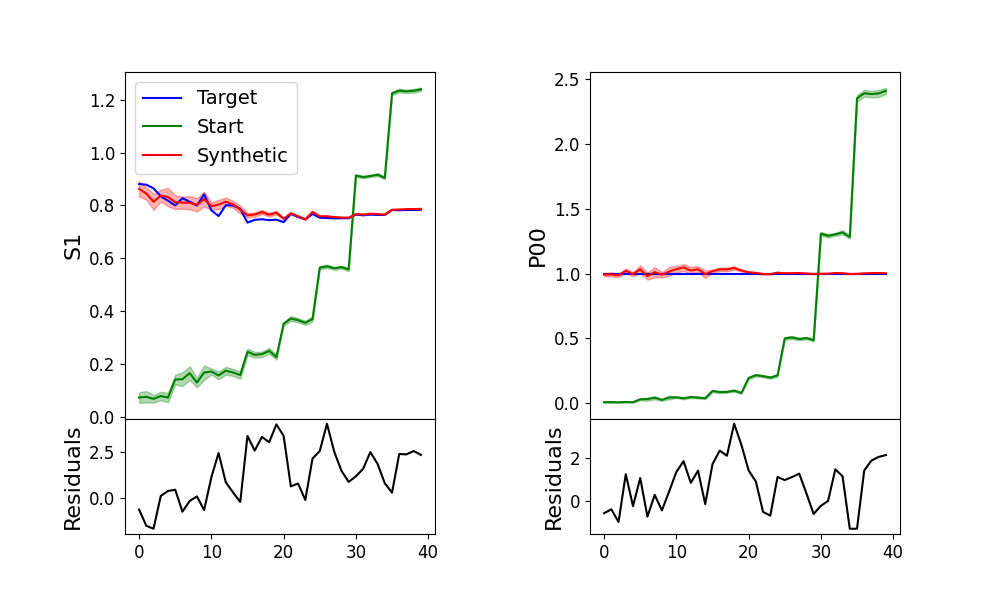

In [20]:
fig, axs = plt.subplots(2, 2, sharex='col', figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})
axs = axs.ravel()
(ax0, ax1, ax2, ax3) = axs

fig.subplots_adjust(hspace=0, wspace=0.5)

# S1
xxS1 = np.arange(tS1.size)
ax0.plot(tS1, color='b', label='Target')

ax0.plot(meanS1_start, color='g', label='Start')
ax0.fill_between(xxS1, meanS1_start - stdS1_start, meanS1_start + stdS1_start, color='g', alpha=0.3)

#ax0.plot(meanS1_gauss, color='orange', label='Gaussian')
#ax0.fill_between(xxS1, meanS1_gauss - stdS1_gauss, meanS1_gauss + stdS1_gauss, color='orange', alpha=0.3)

ax0.plot(meanS1_end, color='r', label='Synthetic')
ax0.fill_between(xxS1, meanS1_end - stdS1_end, meanS1_end + stdS1_end, color='r', alpha=0.3)

ax0.set_ylabel('S1')
ax0.legend()

# P00
xxP00 = np.arange(tP00.size)
ax1.plot(tP00, color='b')

ax1.plot(meanP00_start, color='g', label='Start')
ax1.fill_between(xxP00, meanP00_start - stdP00_start, meanP00_start + stdP00_start, color='g', alpha=0.3)

#ax1.plot(meanP00_gauss, color='orange', label='Gaussian')
#ax1.fill_between(xxP00, meanP00_gauss - stdP00_gauss, meanP00_gauss + stdP00_gauss, color='orange', alpha=0.3)

ax1.plot(meanP00_end, color='r', label='Synthetic')
ax1.fill_between(xxP00, meanP00_end - stdP00_end, meanP00_end + stdP00_end, color='r', alpha=0.3)

ax1.set_ylabel('P00')

# S1
xxS1 = np.arange(tS1.size)
ax2.plot((meanS1_end - tS1) / stdS1_end , color='k')
ax2.set_ylabel('Residuals')

# P00
xxP00 = np.arange(tP00.size)
ax3.plot((meanP00_end - tP00) / stdP00_end , color='k')
ax3.set_ylabel('Residuals')

#fig.tight_layout()

fig.savefig(save_plot_dir + f'S1_P00_{sky}.pdf')

<IPython.core.display.Javascript object>


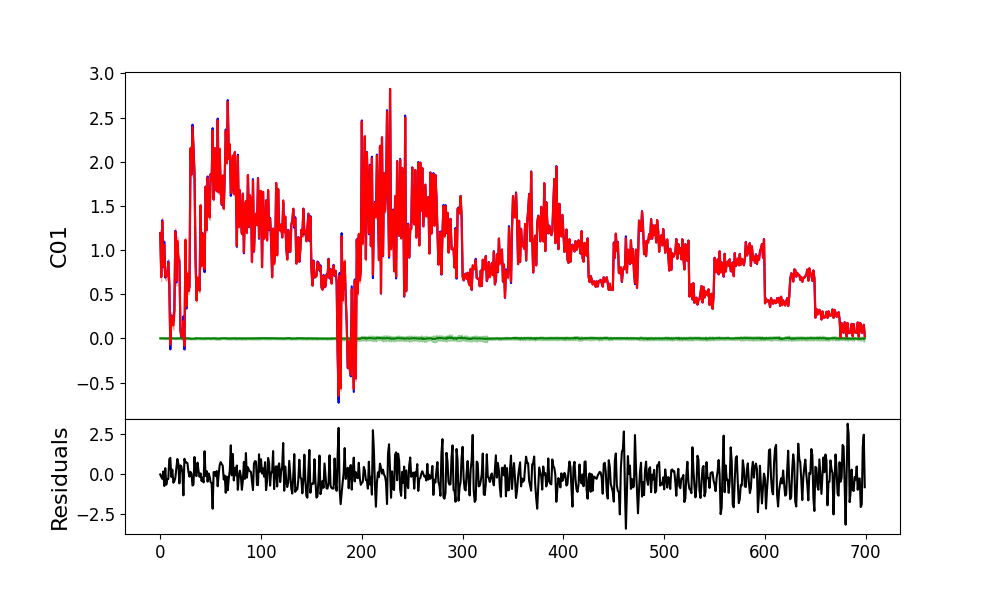

In [21]:
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})
axs = axs.ravel()
(ax0, ax1) = axs
fig.subplots_adjust(hspace=0)

# C01
xxC01 = np.arange(tC01.size)
ax0.plot(tC01, color='b')

ax0.plot(meanC01_start, color='g', label='Start')
ax0.fill_between(xxC01, meanC01_start - stdC01_start, meanC01_start + stdC01_start, color='g', alpha=0.3)

#ax0.plot(meanC01_gauss, color='orange', label='Gaussian')
#ax0.fill_between(xxC01, meanC01_gauss - stdC01_gauss, meanC01_gauss + stdC01_gauss, color='orange', alpha=0.3)

ax0.plot(meanC01_end, color='r', label='Synthetic')
ax0.fill_between(xxC01, meanC01_end - stdC01_end, meanC01_end + stdC01_end, color='r', alpha=0.3)

ax0.set_ylabel('C01')

xxC01 = np.arange(tC01.size)
ax1.plot((meanC01_end - tC01) / stdC01_end , color='k')
ax1.set_ylabel('Residuals')

#fig.tight_layout()

fig.savefig(save_plot_dir + f'C01_{sky}.pdf')

<IPython.core.display.Javascript object>


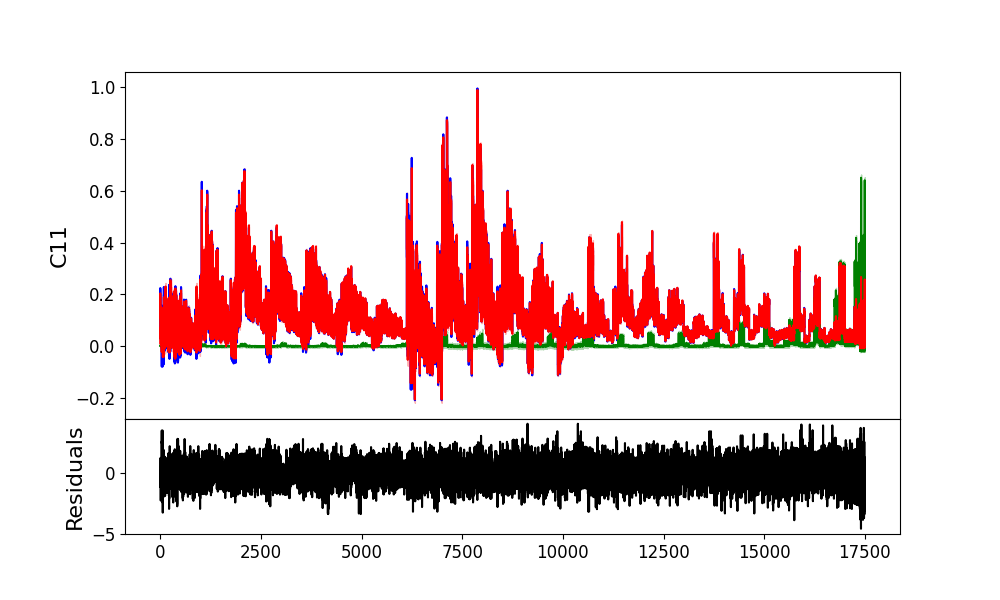

In [19]:
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})
axs = axs.ravel()
(ax0, ax1) = axs
fig.subplots_adjust(hspace=0)

# C11
xxC11 = np.arange(tC11.size)
ax0.plot(tC11, color='b')

ax0.plot(meanC11_start, color='g', label='Start')
ax0.fill_between(xxC11, meanC11_start - stdC11_start, meanC11_start + stdC11_start, color='g', alpha=0.3)

#ax0.plot(meanC11_gauss, color='orange', label='Gaussian')
#ax0.fill_between(xxC11, meanC11_gauss - stdC11_gauss, meanC11_gauss + stdC11_gauss, color='orange', alpha=0.3)

ax0.plot(meanC11_end, color='r', label='Synthetic')
ax0.fill_between(xxC11, meanC11_end - stdC11_end, meanC11_end + stdC11_end, color='r', alpha=0.3)

ax0.set_ylabel('C11')
#ax0.set_xlim(6000, 6100)

# Residuals
xxC11 = np.arange(tC11.size)
ax1.plot((meanC11_end - tC11) / stdC11_end , color='k')
ax1.set_ylabel('Residuals')
#ax1.set_xlim(6000, 6100)

#fig.tight_layout()

fig.savefig(save_plot_dir + f'C11_{sky}.pdf')

<IPython.core.display.Javascript object>


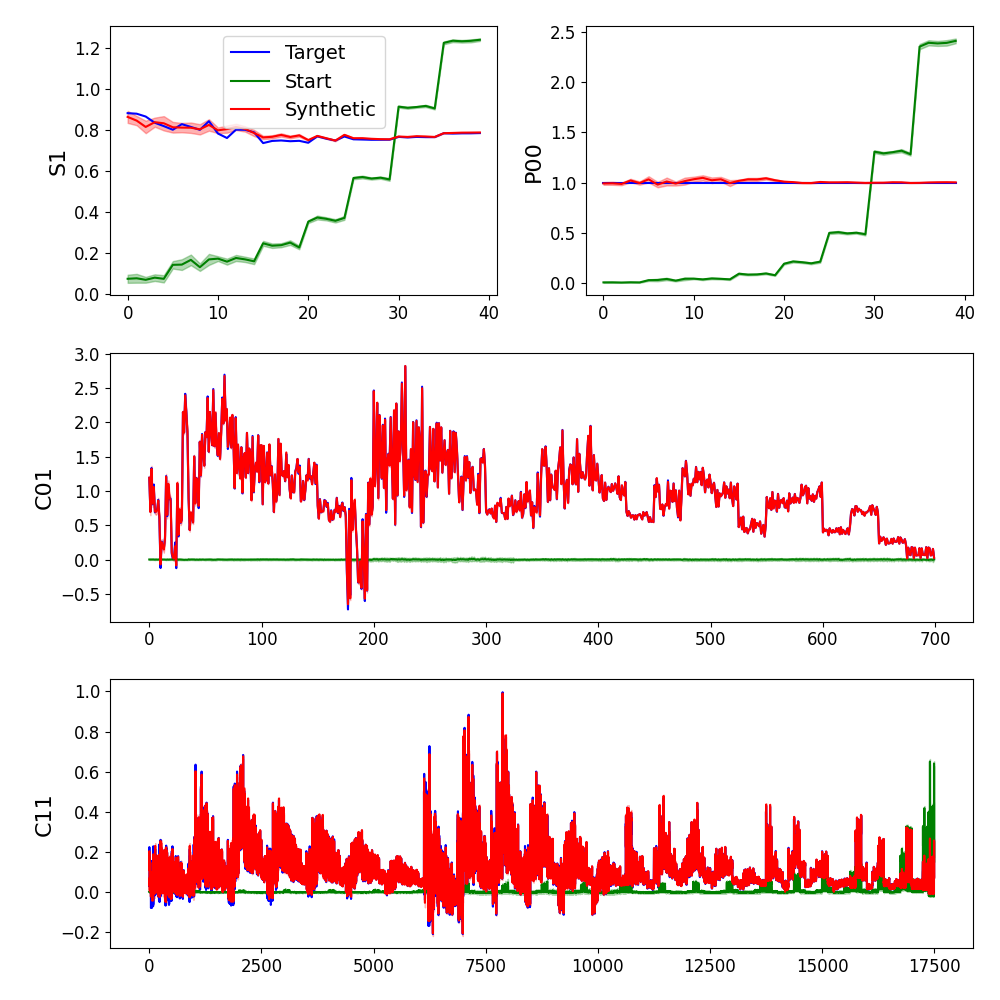

In [29]:
fig, axs = plt.subplot_mosaic("AB;CC;DD", figsize=(10, 10))

# S1
xxS1 = np.arange(tS1.size)
axs['A'].plot(tS1, color='b', label='Target')

axs['A'].plot(meanS1_start, color='g', label='Start')
axs['A'].fill_between(xxS1, meanS1_start - stdS1_start, meanS1_start + stdS1_start, color='g', alpha=0.3)

#axs['A'].plot(meanS1_gauss, color='orange', label='Gaussian')
#axs['A'].fill_between(xxS1, meanS1_gauss - stdS1_gauss, meanS1_gauss + stdS1_gauss, color='orange', alpha=0.3)

axs['A'].plot(meanS1_end, color='r', label='Synthetic')
axs['A'].fill_between(xxS1, meanS1_end - stdS1_end, meanS1_end + stdS1_end, color='r', alpha=0.3)

axs['A'].set_ylabel('S1')
axs['A'].legend()

# P00
xxP00 = np.arange(tP00.size)
axs['B'].plot(tP00, color='b')

axs['B'].plot(meanP00_start, color='g', label='Start')
axs['B'].fill_between(xxP00, meanP00_start - stdP00_start, meanP00_start + stdP00_start, color='g', alpha=0.3)

#axs['B'].plot(meanP00_gauss, color='orange', label='Gaussian')
#axs['B'].fill_between(xxP00, meanP00_gauss - stdP00_gauss, meanP00_gauss + stdP00_gauss, color='orange', alpha=0.3)

axs['B'].plot(meanP00_end, color='r', label='Synthetic')
axs['B'].fill_between(xxP00, meanP00_end - stdP00_end, meanP00_end + stdP00_end, color='r', alpha=0.3)

axs['B'].set_ylabel('P00')

# C01
xxC01 = np.arange(tC01.size)
axs['C'].plot(tC01, color='b')

axs['C'].plot(meanC01_start, color='g', label='Start')
axs['C'].fill_between(xxC01, meanC01_start - stdC01_start, meanC01_start + stdC01_start, color='g', alpha=0.3)

#axs['C'].plot(meanC01_gauss, color='orange', label='Gaussian')
#axs['C'].fill_between(xxC01, meanC01_gauss - stdC01_gauss, meanC01_gauss + stdC01_gauss, color='orange', alpha=0.3)

axs['C'].plot(meanC01_end, color='r', label='Synthetic')
axs['C'].fill_between(xxC01, meanC01_end - stdC01_end, meanC01_end + stdC01_end, color='r', alpha=0.3)

axs['C'].set_ylabel('C01')

# C11
xxC11 = np.arange(tC11.size)
axs['D'].plot(tC11, color='b')

axs['D'].plot(meanC11_start, color='g', label='Start')
axs['D'].fill_between(xxC11, meanC11_start - stdC11_start, meanC11_start + stdC11_start, color='g', alpha=0.3)

#axs['D'].plot(meanC11_gauss, color='orange', label='Gaussian')
#axs['D'].fill_between(xxC11, meanC11_gauss - stdC11_gauss, meanC11_gauss + stdC11_gauss, color='orange', alpha=0.3)

axs['D'].plot(meanC11_end, color='r', label='Synthetic')
axs['D'].fill_between(xxC11, meanC11_end - stdC11_end, meanC11_end + stdC11_end, color='r', alpha=0.3)

axs['D'].set_ylabel('C11')
#axs['D'].set_xlim(6000, 6100)

fig.tight_layout()

fig.savefig(save_plot_dir + f'coeffs_{sky}.pdf')

<IPython.core.display.Javascript object>


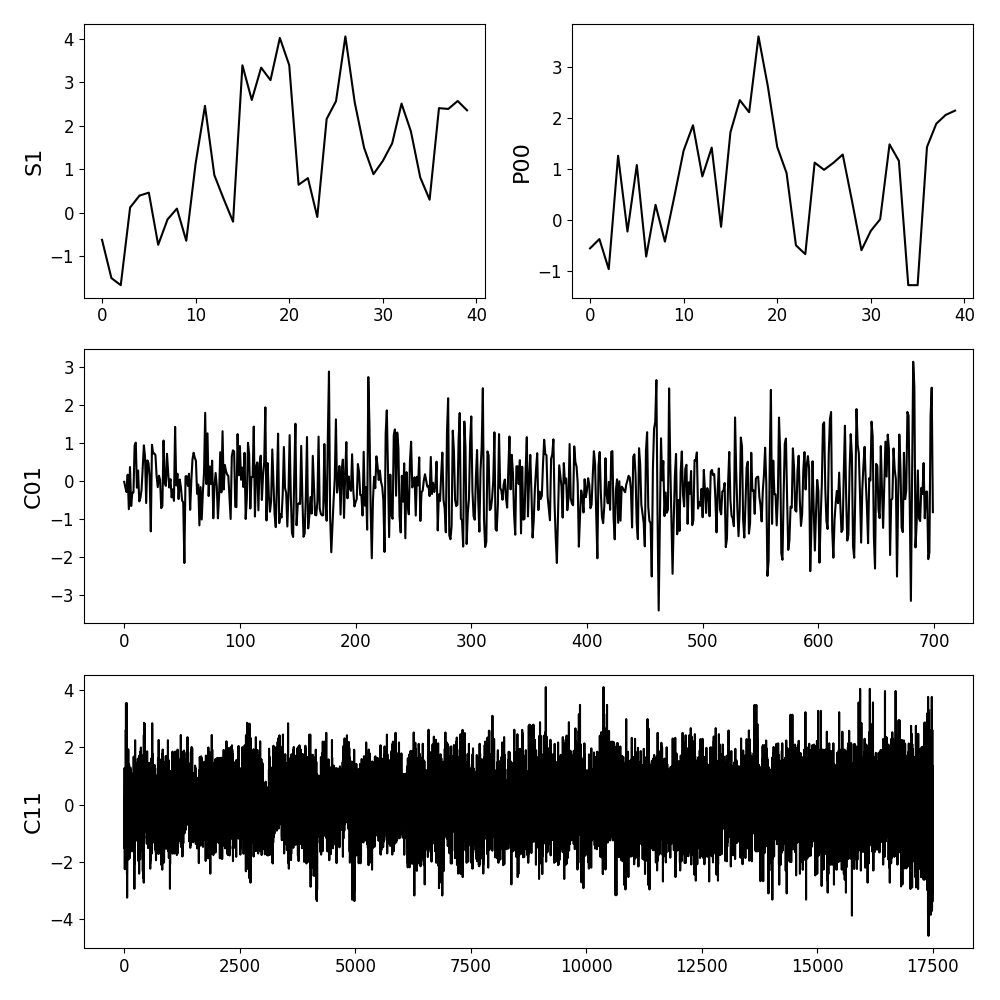

In [30]:
fig, axs = plt.subplot_mosaic("AB;CC;DD", figsize=(10, 10))

# S1
xxS1 = np.arange(tS1.size)
axs['A'].plot((meanS1_end - tS1) / stdS1_end , color='k')
axs['A'].set_ylabel('S1')

# P00
xxP00 = np.arange(tP00.size)
axs['B'].plot((meanP00_end - tP00) / stdP00_end , color='k')
axs['B'].set_ylabel('P00')

# C01
xxC01 = np.arange(tC01.size)
axs['C'].plot((meanC01_end - tC01) / stdC01_end , color='k')
axs['C'].set_ylabel('C01')

# C11
xxC11 = np.arange(tC11.size)
axs['D'].plot((meanC11_end - tC11) / stdC11_end , color='k')
axs['D'].set_ylabel('C11')
#axs['D'].set_xlim(6000, 6100)

fig.tight_layout()

# Figure 6: power spectrum

In [78]:
sky = 'venus'
ps_target = np.load(save_plot_dir + f'ps_target_{sky}.npy')
mean_ps_end = np.load(save_plot_dir + f'ps_end_mean_{sky}.npy')
std_ps_end = np.load(save_plot_dir + f'ps_end_std_{sky}.npy')

mean_ps_start = np.load(save_plot_dir + f'ps_start_mean_{sky}.npy')
std_ps_start = np.load(save_plot_dir + f'ps_start_std_{sky}.npy')

<IPython.core.display.Javascript object>


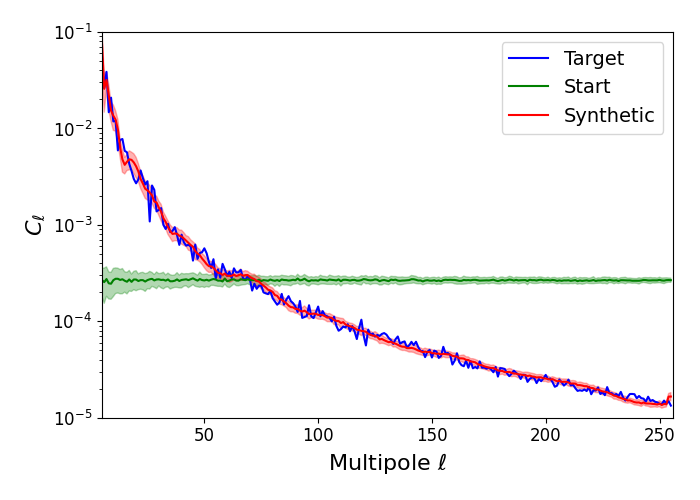

In [80]:
L = 256
J_min = 2
lam=2
xx = np.arange(256)
lmin = int(lam**J_min) + 1

### Plot
plt.figure(figsize=(7, 5))

plt.plot(ps_target, 'b', label="Target")

plt.plot(mean_ps_start, 'g', label="Start")
plt.fill_between(xx, mean_ps_start - std_ps_start, mean_ps_start + std_ps_start, color='g', alpha=0.3)

plt.plot(mean_ps_end, 'r', label="Synthetic")
plt.fill_between(xx, mean_ps_end - std_ps_end, mean_ps_end + std_ps_end, color='r', alpha=0.3)

plt.yscale("log")
#plt.xscale("log", base=2)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$C_\ell$')
plt.xlim(lmin, L)
plt.ylim(1e-5, 1e-1)
plt.legend()

plt.tight_layout()

plt.savefig(save_plot_dir + f'ps_{sky}.pdf')

# PDF in healpix format

In [36]:
sky = 'tsz'

bins_centers = np.load(save_plot_dir + f'bin_centers_{sky}.npy')

thist = np.load(save_plot_dir + f'hist_target_{sky}.npy')

mean_hist_gauss = np.load(save_plot_dir + f'hist_gauss_mean_{sky}.npy')
std_hist_gauss = np.load(save_plot_dir + f'hist_gauss_std_{sky}.npy')

mean_hist_end = np.load(save_plot_dir + f'hist_end_mean_{sky}.npy')
std_hist_end = np.load(save_plot_dir + f'hist_end_std_{sky}.npy')

mean_hist_start = np.load(save_plot_dir + f'hist_start_mean_{sky}.npy')
std_hist_start = np.load(save_plot_dir + f'hist_start_std_{sky}.npy')

<IPython.core.display.Javascript object>


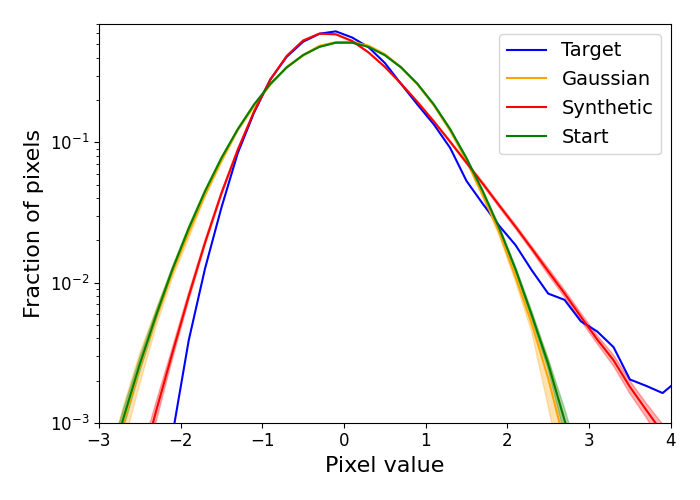

In [38]:
plt.figure(figsize=(7, 5))
plt.plot(bins_centers, thist, color='b', label='Target')

plt.plot(bins_centers, mean_hist_gauss, color='orange', label='Gaussian')
plt.fill_between(bins_centers, mean_hist_gauss - std_hist_gauss, mean_hist_gauss + std_hist_gauss, 
                 color='orange', alpha=0.3)

plt.plot(bins_centers, mean_hist_end, color='r', label='Synthetic')
plt.fill_between(bins_centers, mean_hist_end - std_hist_end, mean_hist_end + std_hist_end, 
                 color='r', alpha=0.3)

plt.plot(bins_centers, mean_hist_start, color='g', label='Start')
plt.fill_between(bins_centers, mean_hist_start - std_hist_start, mean_hist_start + std_hist_start, 
                 color='g', alpha=0.3)

#plt.title('Hpx')
plt.xlabel('Pixel value')
plt.ylabel('Fraction of pixels')
plt.legend(loc='upper right')
plt.yscale("log")
plt.ylim(1e-3, 0.7)
plt.xlim(-3, 4)

plt.tight_layout()

plt.savefig(save_plot_dir + f'hist_hpx_{sky}.pdf')

# Minkowski

In [ ]:
np.save(save_plot_dir + f'Minko_us_{sky}.npy', us)
np.save(save_plot_dir + f'Minko_target_{sky}.npy', Minko_target)

np.save(save_plot_dir + f'Minko_gauss_mean_{sky}.npy', mean_gauss)
np.save(save_plot_dir + f'Minko_gauss_std_{sky}.npy', std_gauss)

np.save(save_plot_dir + f'Minko_start_mean_{sky}.npy', mean_start)
np.save(save_plot_dir + f'Minko_start_std_{sky}.npy', std_start)

np.save(save_plot_dir + f'Minko_end_mean_{sky}.npy', mean_end)
np.save(save_plot_dir + f'Minko_end_std_{sky}.npy', std_end)

In [4]:
sky = 'lensing'

us = np.load(save_plot_dir + f'Minko_us_{sky}.npy')
Minko_target = np.load(save_plot_dir + f'Minko_target_{sky}.npy')

mean_gauss = np.load(save_plot_dir + f'Minko_gauss_mean_{sky}.npy')
std_gauss = np.load(save_plot_dir + f'Minko_gauss_std_{sky}.npy')

mean_start = np.load(save_plot_dir + f'Minko_start_mean_{sky}.npy')
std_start = np.load(save_plot_dir + f'Minko_start_std_{sky}.npy')

mean_end = np.load(save_plot_dir + f'Minko_end_mean_{sky}.npy')
std_end = np.load(save_plot_dir + f'Minko_end_std_{sky}.npy')

<IPython.core.display.Javascript object>


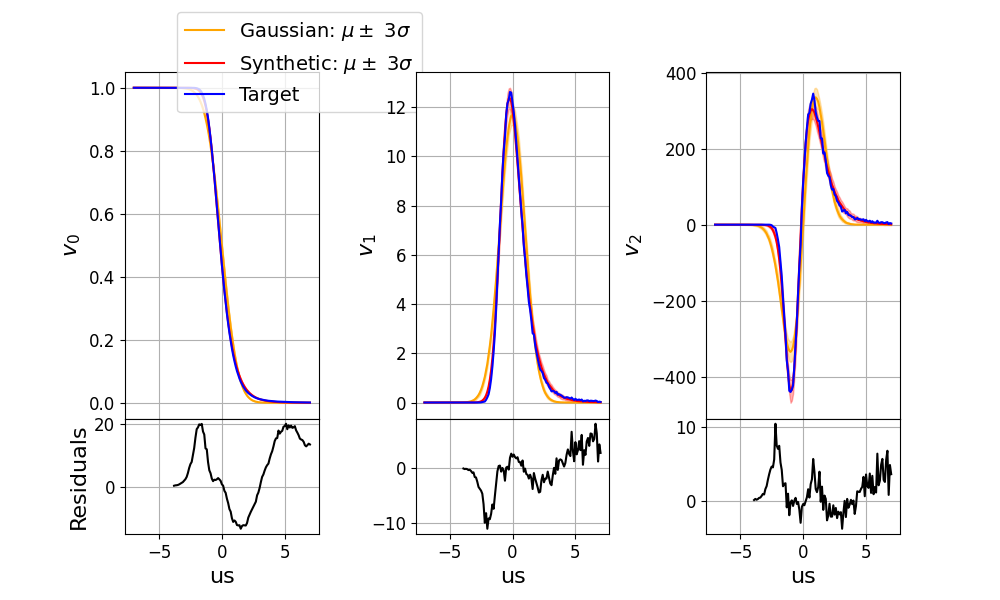

In [17]:
fig, axs = plt.subplots(2, 3, sharex='col', figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})
axs = axs.ravel()
(ax0, ax1, ax2, ax3, ax4, ax5) = axs
fig.subplots_adjust(hspace=0, wspace=0.5)

ns = 3
#ax0.plot(us, mean_start[0, :], color='g', label='Start')
#ax0.fill_between(us,  mean_start[0, :] - std_start[0, :],  mean_start[0, :] + std_start[0, :], color='g', alpha=0.3)
ax0.plot(us, mean_gauss[0, :], color='orange', label=fr'Gaussian: $\mu \pm$ {ns}$\sigma$')
ax0.fill_between(us, mean_gauss[0, :] - ns*std_gauss[0, :], mean_gauss[0, :] + ns*std_gauss[0, :], color='orange', alpha=0.3)
ax0.plot(us, mean_end[0, :], color='r', label=fr'Synthetic: $\mu \pm$ {ns}$\sigma$')
ax0.fill_between(us, mean_end[0, :] - ns*std_end[0, :], mean_end[0, :] + ns*std_end[0, :], color='r', alpha=0.3)
ax0.plot(us, Minko_target[0, :], color='b', label='Target')
ax0.set_ylabel(r'$v_0$')
ax0.grid()
ax0.legend(loc='upper center', bbox_to_anchor=(0.9, 1.2), ncol=1, fontsize=14)

#ax1.plot(us, mean_start[1, :], color='g', label='Start')
#ax1.fill_between(us,  mean_start[1, :] - std_start[1, :],  mean_start[1, :] + std_start[1, :], color='g', alpha=0.3)
ax1.plot(us, mean_gauss[1, :], color='orange', label=fr'Gaussian: $\mu \pm$ {ns}$\sigma$')
ax1.fill_between(us, mean_gauss[1, :] - ns*std_gauss[1, :], mean_gauss[1, :] + ns*std_gauss[1, :], color='orange', alpha=0.3)
ax1.plot(us, mean_end[1, :], color='r', label=fr'Synthetic: $\mu \pm$ {ns}$\sigma$')
ax1.fill_between(us, mean_end[1, :] - ns*std_end[1, :], mean_end[1, :] + ns*std_end[1, :], color='r', alpha=0.3)
ax1.plot(us, Minko_target[1, :], color='b', label='Target')
ax1.set_ylabel(r'$v_1$')
ax1.grid()

#ax2.plot(us, mean_start[2, :], color='g', label='Start')
#ax2.fill_between(us,  mean_start[2, :] - std_start[2, :],  mean_start[2, :] + std_start[2, :], color='g', alpha=0.3)
ax2.plot(us, mean_gauss[2, :], color='orange', label=fr'Gaussian: $\mu \pm$ {ns}$\sigma$')
ax2.fill_between(us, mean_gauss[2, :] - ns*std_gauss[2, :], mean_gauss[2, :] + ns*std_gauss[2, :], color='orange', alpha=0.3)
ax2.plot(us, mean_end[2, :], color='r', label=fr'Synthetic: $\mu \pm$ {ns}$\sigma$')
ax2.fill_between(us, mean_end[2, :] - ns*std_end[2, :], mean_end[2, :] + ns*std_end[2, :], color='r', alpha=0.3)
ax2.plot(us, Minko_target[2, :], color='b', label='Target')
ax2.set_ylabel(r'$v_2$')
ax2.grid()
#ax2.legend()

ax3.plot(us, (Minko_target[0, :] - mean_end[0, :])/std_end[0, :], color='k')
ax3.set_xlabel('us')
ax3.set_ylabel('Residuals')
ax3.grid()

ax4.plot(us, (Minko_target[1, :] - mean_end[1, :])/std_end[1, :], color='k')
ax4.set_xlabel('us')
ax4.grid()

ax5.plot(us, (Minko_target[2, :] - mean_end[2, :])/std_end[2, :], color='k')
ax5.set_xlabel('us')
ax5.grid()

#fig.tight_layout()

plt.savefig(save_plot_dir + f'Minko_{sky}.pdf')